# Analyze the predictions of a single run

In [86]:
from read_ggp_run import *
from cells_simulation import *
import scipy.stats

In [87]:
# get files

# directory = '../data/test_new_init_n250_var_g_adder/test_new_init_n250_var_g_adder_{:d}'.format(0)
# sample = 'test_new_init_n250_var_g_adder_{:d}'.format(0)

directory = '../data_2.0/stalled_n1_timer/stalled_n1_timer_{:d}'.format(0)
sample = 'stalled_n1_timer_{:d}'.format(0)


filebase = default_filebase(directory, sample) # default

dat_file = get_data_file(directory, sample)
prediction_file_f, prediction_file_b, prediction_file = get_prediction_files(filebase)


indata = pd.read_csv(dat_file)

prediction = pd.read_csv(prediction_file, skiprows=13)
prediction_f = pd.read_csv(prediction_file_f, skiprows=13)
prediction_b = pd.read_csv(prediction_file_b, skiprows=13)


indata = indata[indata['lane']==0]  
for df in [ prediction, prediction_f, prediction_b]:
    df = df[df['cell_id']==0.0]  


# read files

cells_true = df2cells(indata, time="time_min", log_length="log_length", gfp="gfp", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="lt", qt="qt")


cells_prediction = ggp_df2cells(prediction, time="time", log_length="mean_x", gfp="mean_g", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="mean_l", qt="mean_q")

cells_prediction_f = ggp_df2cells(prediction_f, time="time", log_length="mean_x", gfp="mean_g", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="mean_l", qt="mean_q")                          

cells_prediction_b = ggp_df2cells(prediction_b, time="time", log_length="mean_x", gfp="mean_g", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="mean_l", qt="mean_q")

cells_noise = df2cells(indata, time="time_min", log_length="log_length_noise", gfp="gfp_noise", 
                            cell_id="cell_id", parent_id="parent_id", 
                            lt="lt", qt="qt")

In [88]:
# paths
paths_true = cell_paths(cells_true[0], cells_true)

paths_prediction = cell_paths(cells_prediction[0], cells_prediction)
paths_prediction_f = cell_paths(cells_prediction_f[0], cells_prediction_f)
paths_prediction_b = cell_paths(cells_prediction_b[0], cells_prediction_b)

paths_noise = cell_paths(cells_noise[0], cells_noise)

## log length and gfp

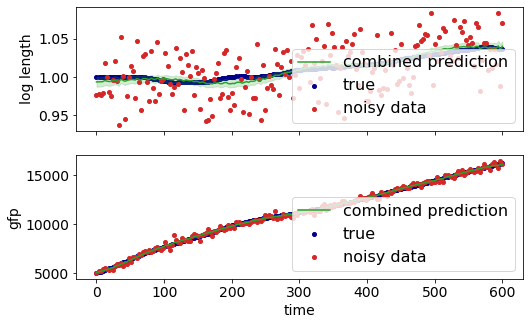

In [89]:
fig, axes = plt.subplots(2,1, figsize=(8,5), sharex=True)
ax = axes.ravel()

start_cell = 0
last_cells=start_cell+1
s=4**2
### Log length
c = "darkblue"
l = "true"
ls = '-'
for cell in paths_true[0][start_cell:last_cells]:
    ax[0].scatter(cell.time, cell.log_length, label=l, color=c, ls=ls, s=s)  
    l = None

c = "tab:green"
l = "combined prediction"
ls = '-'
for cell in paths_prediction[0][start_cell:last_cells]:
    ax[0].fill_between(cell.time, cell.log_length-np.sqrt(cell.cov_xx), cell.log_length+np.sqrt(cell.cov_xx), 
                    color=c, ls=ls, alpha=0.2)
    ax[0].plot(cell.time, cell.log_length, label=l, color=c, ls=ls) 
    l = None

c = "tab:red"
l = "noisy data"
for cell in paths_noise[0][start_cell:last_cells]:
    ax[0].scatter(cell.time, cell.log_length, label=l, color=c, ls=ls, s=s)      
    l = None


### gfp
c = "darkblue"
l = "true"
ls = '-'
for cell in paths_true[0][start_cell:last_cells]:
    ax[1].scatter(cell.time, cell.gfp, label=l, color=c, ls=ls, s=s)  
    l = None

c = "tab:green"
l = "combined prediction"
ls = '-'
for cell in paths_prediction[0][start_cell:last_cells]:
    ax[1].fill_between(cell.time, cell.gfp-np.sqrt(cell.cov_gg), cell.gfp+np.sqrt(cell.cov_gg), 
                    color=c, ls=ls, alpha=0.2)
    ax[1].plot(cell.time, cell.gfp, label=l, color=c, ls=ls) 
    l = None

c = "tab:red"
l = "noisy data"
for cell in paths_noise[0][start_cell:last_cells]:
    ax[1].scatter(cell.time, cell.gfp, label=l, color=c, ls=ls, s=s)      
    l = None

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('log length')
ax[1].set_ylabel('gfp')

ax[1].set_xlabel('time')    
plt.show()

## Deviation from "truth"

In [90]:
def plot_deviation(paths, predition_dev, noisy_dev, err_bars, path_index=0, title=""):

    super_cell = cocanate_cells(paths[path_index])

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005

    rect_scatter = [left, bottom, width, height]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    # plt.figure(figsize=(10, 5))
    plt.figure(figsize=(14, 7))

    ax = plt.axes(rect_scatter)
    ax.set_title(title + "| lineage path {:d}".format(path_index))
    ax.tick_params(direction='in', top=True, right=True)

    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    ###
    ax.set_xlabel("time")
    ax.axhline(0,color='black', lw=0.5)
    ax.scatter(super_cell.time, noisy_dev, color='tab:red', s=3**2, label="noise")
    # ax.plot(super_cell.time, noisy_dev, color='tab:red')

    ax.errorbar(super_cell.time, predition_dev, yerr=err_bars, color='tab:green',  fmt='o', ms=3, label="deviation prediction")

    label = "cell division"
    for cell in paths[path_index]:
        ax.axvline(cell.time[0],color='grey', ls='--', label=label)
        label=None
    ax.set_xlim(left=0, right=super_cell.time[-1])
    #### Hist
    ax_histy.hist(noisy_dev, bins='auto', orientation='horizontal', alpha=0.5, color='tab:red', density=True)
    ax_histy.hist(predition_dev, bins='auto', orientation='horizontal', alpha=0.5, color='tab:green', density=True)
    ax_histy.set_xticks([])

    ax.legend()

    plt.show()

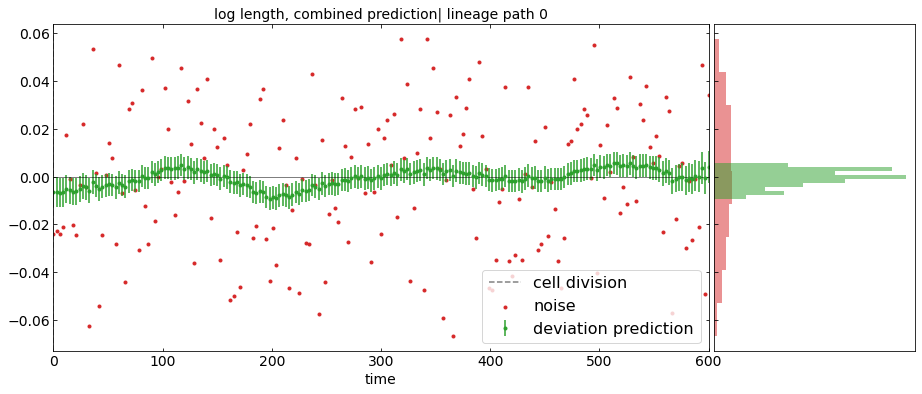

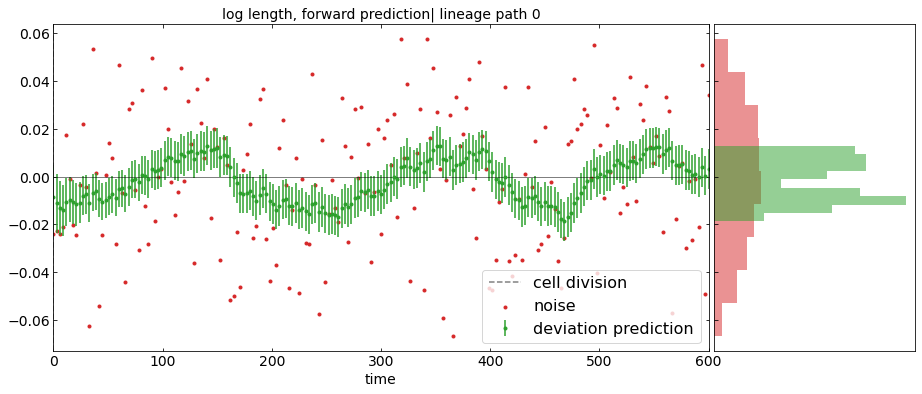

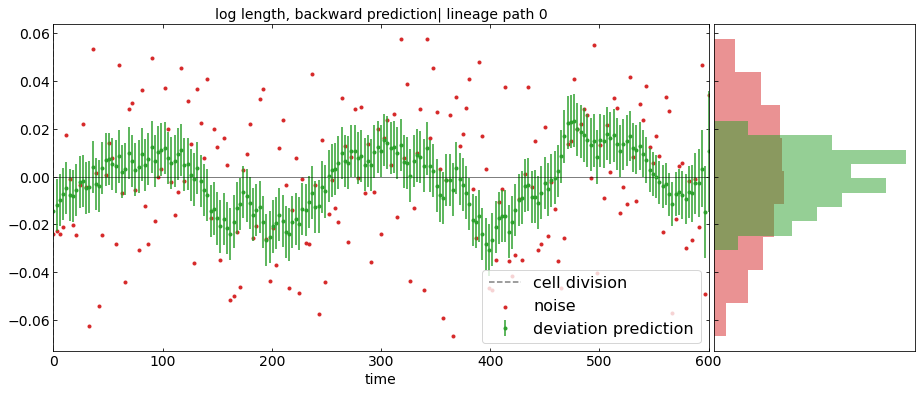

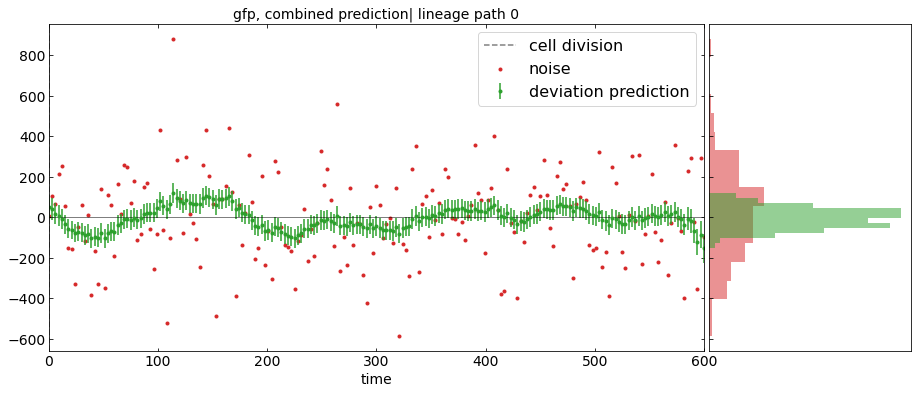

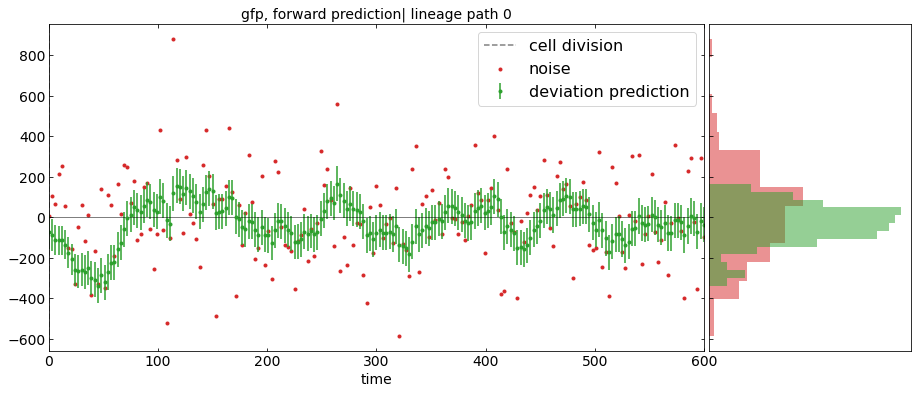

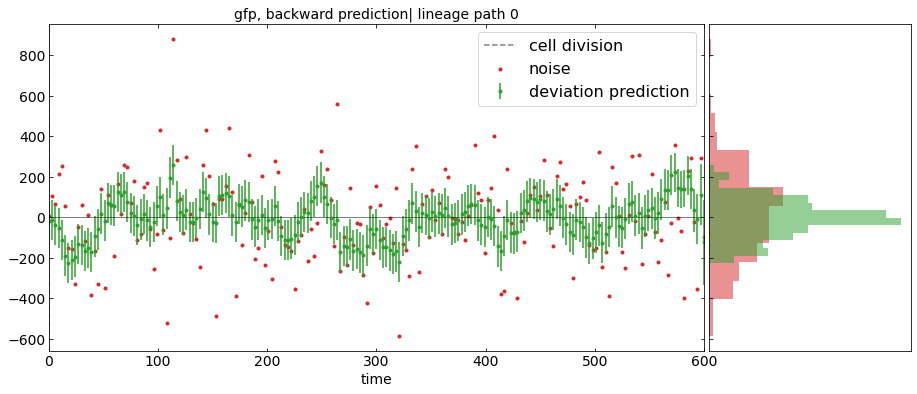

In [91]:
paths_length = [len(path) for path in paths_true]
# path_index = np.argmax(paths_length)
path_index = 0
super_cell_t = cocanate_cells(paths_true[path_index])
super_cell_p = cocanate_ggp_cells(paths_prediction[path_index])
super_cell_pf = cocanate_ggp_cells(paths_prediction_f[path_index])
super_cell_pb = cocanate_ggp_cells(paths_prediction_b[path_index])

super_cell_n = cocanate_cells(paths_noise[path_index])



### LOG LENTGH
for super_p, title in [ (super_cell_p, "log length, combined prediction"), 
                        (super_cell_pf, "log length, forward prediction"), 
                        (super_cell_pb, "log length, backward prediction")]:
    predition_dev_log_length = np.array(super_p.log_length) - np.array(super_cell_t.log_length)
    log_length_err_bars = np.sqrt(super_p.cov_xx)
    noisy_dev_log_length = np.array(super_cell_n.log_length) - np.array(super_cell_t.log_length)

    plot_deviation(paths_true, predition_dev_log_length, noisy_dev_log_length, 
                    log_length_err_bars, path_index=path_index, title=title)


### GFP
for super_p, title in [ (super_cell_p, "gfp, combined prediction"), 
                        (super_cell_pf, "gfp, forward prediction"), 
                        (super_cell_pb, "gfp, backward prediction")]:

    predition_dev_gfp = np.array(super_p.gfp) - np.array(super_cell_t.gfp)
    noisy_dev_gfp = np.array(super_cell_n.gfp) - np.array(super_cell_t.gfp)
    gfp_err_bars = np.sqrt(super_p.cov_gg)

    plot_deviation(paths_true, predition_dev_gfp, noisy_dev_gfp, gfp_err_bars, path_index=path_index, title=title)


## Lambda and q

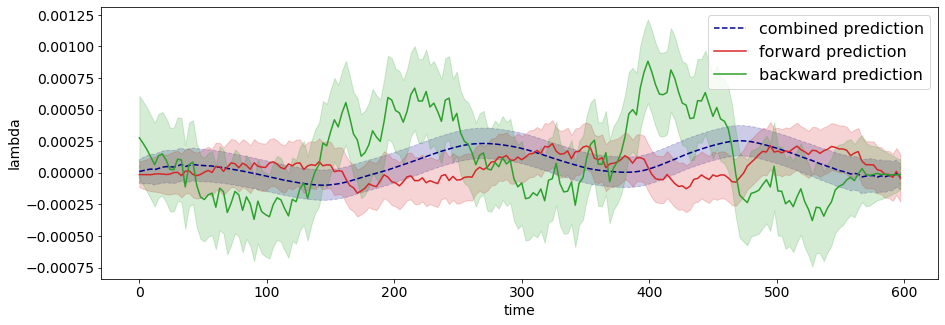

In [92]:

t0, t1 = 0, -1

### all at once
fig, ax = plt.subplots(figsize=(15,5), sharex=True)
for p, l,c, ls in [ #(paths_true, "true", "tab:blue", '-'),
                    (paths_prediction, "combined prediction", 'darkblue', '--'), 
                    (paths_prediction_f, "forward prediction", 'tab:red', '-'), 
                    (paths_prediction_b, "backward prediction", 'tab:green', '-')]:
    if l == "true":
        super_cell= cocanate_cells(p[0])
    else: 
        super_cell = cocanate_ggp_cells(p[0])
        ax.fill_between(super_cell.time[t0:t1],
                        super_cell.lt[t0:t1]-np.sqrt(super_cell.cov_ll[t0:t1]), 
                        super_cell.lt[t0:t1]+np.sqrt(super_cell.cov_ll[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)


    ax.plot(super_cell.time[t0:t1], super_cell.lt[t0:t1], label=l, color=c, ls=ls)

ax.set_ylabel('lambda')
ax.set_xlabel('time')

ax.legend()
plt.show()


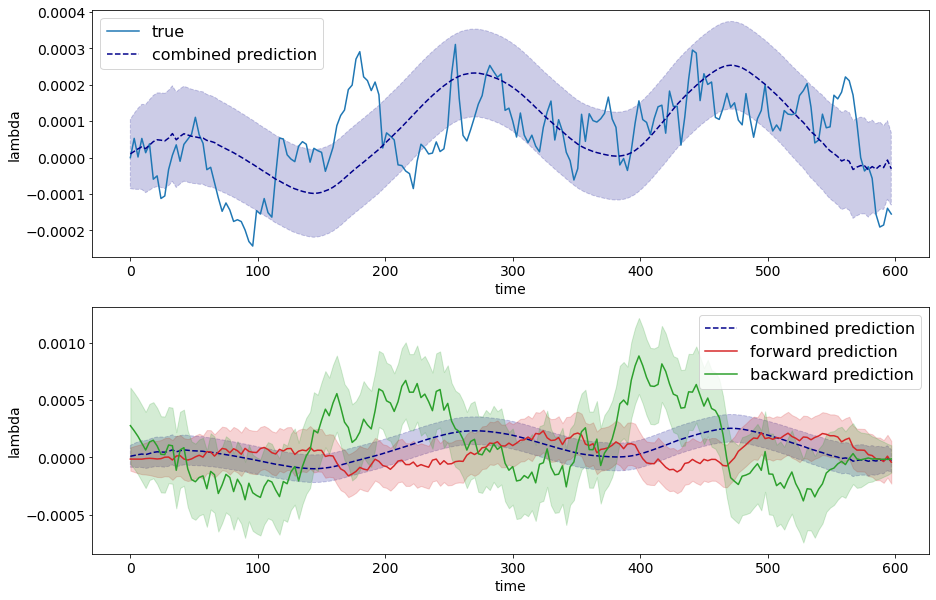

In [93]:
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=False)
ax = axes.ravel()
t0, t1 = 0, -1
path_index = 0
for p, l,c, ls in [(paths_true, "true", "tab:blue", '-'),
            (paths_prediction, "combined prediction", 'darkblue', '--')
            ]:
    if l == "true":
        super_cell= cocanate_cells(p[path_index])
    else: 
        super_cell = cocanate_ggp_cells(p[path_index])
        ax[0].fill_between(super_cell.time[t0:t1],
                        super_cell.lt[t0:t1]-np.sqrt(super_cell.cov_ll[t0:t1]), 
                        super_cell.lt[t0:t1]+np.sqrt(super_cell.cov_ll[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)
    ax[0].plot(super_cell.time[t0:t1], super_cell.lt[t0:t1], label=l, color=c, ls=ls)


for p, l,c, ls in [
            (paths_prediction, "combined prediction", 'darkblue', '--'), 
            (paths_prediction_f, "forward prediction", 'tab:red', '-'), 
            (paths_prediction_b, "backward prediction", 'tab:green', '-')]:
    if l == "true":
        super_cell= cocanate_cells(p[path_index])
    else: 
        super_cell= cocanate_ggp_cells(p[path_index])
        ax[1].fill_between(super_cell.time[t0:t1],
                        super_cell.lt[t0:t1]-np.sqrt(super_cell.cov_ll[t0:t1]), 
                        super_cell.lt[t0:t1]+np.sqrt(super_cell.cov_ll[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)
    ax[1].plot(super_cell.time[t0:t1], super_cell.lt[t0:t1], label=l, color=c, ls=ls)



ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('lambda')
ax[1].set_ylabel('lambda')

ax[0].set_xlabel('time')

ax[1].set_xlabel('time')
plt.show()


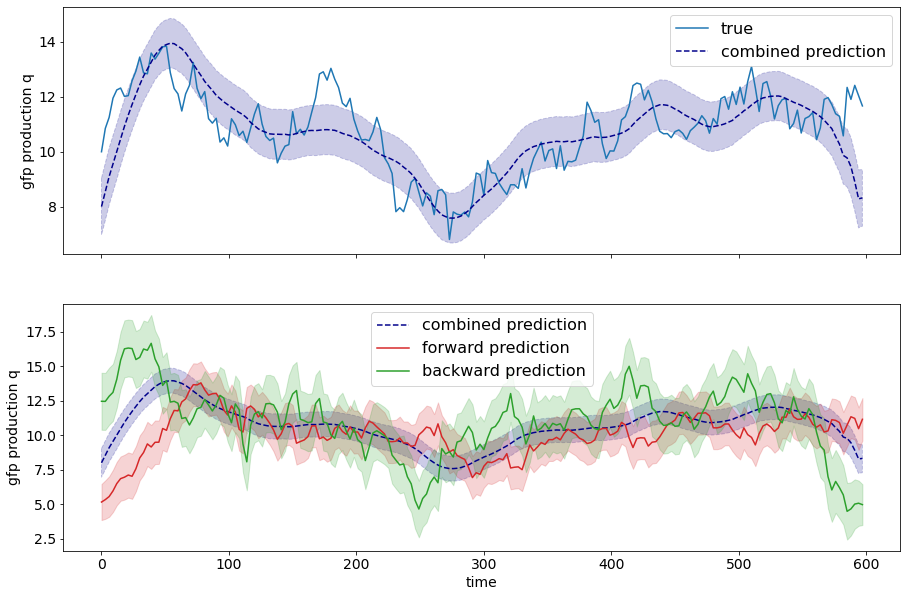

In [94]:
fig, axes = plt.subplots(2,1, figsize=(15,10), sharex=True)
ax = axes.ravel()
t0, t1 = 0, -1

for p, l,c, ls in [(paths_true, "true", "tab:blue", '-'),
            (paths_prediction, "combined prediction", 'darkblue', '--')
            ]:
    if l == "true":
        super_cell = cocanate_cells(p[0])
    else: 
        super_cell = cocanate_ggp_cells(p[0])
        ax[0].fill_between(super_cell.time[t0:t1],
                        super_cell.qt[t0:t1]-np.sqrt(super_cell.cov_qq[t0:t1]), 
                        super_cell.qt[t0:t1]+np.sqrt(super_cell.cov_qq[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)
    ax[0].plot(super_cell.time[t0:t1], super_cell.qt[t0:t1], label=l, color=c, ls=ls)


for p, l,c, ls in [
            (paths_prediction, "combined prediction", 'darkblue', '--'), 
            (paths_prediction_f, "forward prediction", 'tab:red', '-'), 
            (paths_prediction_b, "backward prediction", 'tab:green', '-')]:
    if l == "true":
        super_cell = cocanate_cells(p[0])
    else: 
        super_cell = cocanate_ggp_cells(p[0])
        ax[1].fill_between(super_cell.time[t0:t1],
                        super_cell.qt[t0:t1]-np.sqrt(super_cell.cov_qq[t0:t1]), 
                        super_cell.qt[t0:t1]+np.sqrt(super_cell.cov_qq[t0:t1]), 
                        color=c, ls=ls, alpha=0.2)
    ax[1].plot(super_cell.time[t0:t1], super_cell.qt[t0:t1], label=l, color=c, ls=ls)



ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('gfp production q')
ax[1].set_ylabel('gfp production q')

ax[1].set_xlabel('time')
plt.show()


## Lag 

In [95]:
import scipy.signal

def norm_corr(a, b):
    return (np.mean(a*b) - np.mean(a)*np.mean(b))/(np.std(a)*np.std(b))

def auto_corr(a, taumax, dt=1.):
    auto_corrs = [norm_corr(a, a)]
    for tau in np.arange(1,taumax):
        ac = norm_corr(a[tau:], a[:-tau])
        auto_corrs.append(ac)
    time = [t*dt for t in range(len(auto_corrs))]
    return time, auto_corrs

def correlate(a, b, taumax, dt=1.):
    corrs = [norm_corr(a, b)]
    for tau in np.arange(1,taumax):
        co = norm_corr(a[tau:], b[:-tau])
        corrs.append(co)
    time = [t*dt for t in range(len(corrs))]
    return time, corrs


def linear(x, a, b):
    return a*np.array(x) + b

def plot_auto_corr_paths(paths, taumax, dt, OU="lt", title="", ylim=[]):
    fig, ax = plt.subplots( figsize=(8,6))
    slopes_tau0 = []
    ymin = 1
    for p in paths:
        super_cell = cocanate_cells(p)
        if OU == "lt":
            tau, auto_corrs = auto_corr(super_cell.lt, taumax, dt)
        elif OU == "qt":
            tau, auto_corrs = auto_corr(super_cell.qt, taumax, dt)

        ymin = np.min(list(auto_corrs)+[ymin])
        
        i, j = 0, 1
        slopes_tau0.append((auto_corrs[i] - auto_corrs[j])/(tau[i] - tau[j]))

        p = ax.plot(tau, auto_corrs)
        ax.plot(tau, linear(tau, slopes_tau0[-1], 1), color=p[0].get_color(), ls='--', 
                    label='slope {:.4f}'.format(slopes_tau0[-1]))
    # ax[1].hist(slopes_tau0, bins="auto")
    ax.set_ylim([ymin-0.05, 1.05])
    ax.set_ylabel(r"norm. autocorrelation $R(\tau)$")
    ax.set_xlabel(r"$\tau$")
    ax.set_title(title)
    plt.legend()

    plt.show()

# def plot_auto_corr_cells(cells, taumax, dt, OU="lt"):
#     fig, ax = plt.subplots(1, figsize=(8,6))
#     slopes_tau0 = []
#     for cell in cells:
#         if OU == "lt":
#             tau, auto_corrs = auto_corr(np.array(cell.lt)[:], taumax, dt)
#         elif OU == "qt":
#             tau, auto_corrs = auto_corr(np.array(cell.qt)[20:-20], taumax, dt)

#         ax.plot(tau, auto_corrs)
#         slopes_tau0.append((auto_corrs[0] - auto_corrs[1])/(tau[0] - tau[1]))
#     # ax[1].hist(slopes_tau0, bins="auto")
#     plt.show() 

In [96]:
super_cell_true = cocanate_cells(paths_true[0])
super_cell_p = cocanate_cells(paths_prediction[0])
super_cell_pf = cocanate_cells(paths_prediction_f[0])
super_cell_pb= cocanate_cells(paths_prediction_b[0])

arg_max_tau = []
for pair, label in [([super_cell_true, super_cell_p] ,"true, combined"), 
            ([super_cell_true, super_cell_pf],"true, forward"), 
            ([super_cell_true, super_cell_pb],"true, backward"), 
            ([super_cell_pf, super_cell_pb],"forward, backward")
            ]:
    tau_r, corr_r = correlate(pair[0].lt , pair[1].lt, 20, dt=3)
    tau_l, corr_l = correlate(pair[1].lt , pair[0].lt, 20, dt=3)
    tau_l = [ -t for t in tau_l]
    tau = tau_l[::-1]+tau_r
    corr = corr_l[::-1]+corr_r
    plt.plot(tau, corr, label=label)
    arg_max_tau.append(tau[np.argmax(corr)])
    plt.axvline(arg_max_tau[-1], color="grey")

plt.xlabel(r"$\tau$")
plt.ylabel(r"norm. correlation $R(\tau)$")

plt.legend()
plt.show()

TypeError: can't multiply sequence by non-int of type 'list'

## Autocorrelations

76


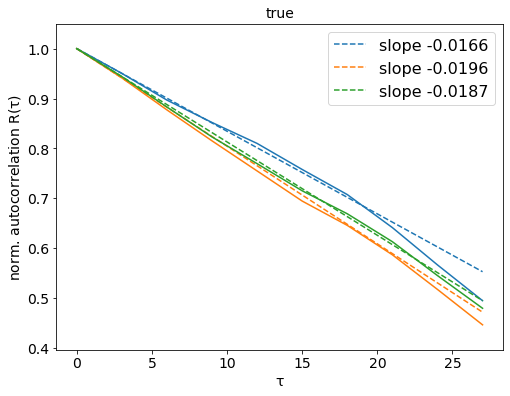

76


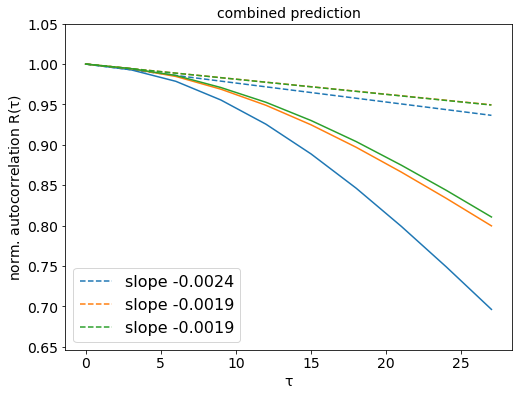

76


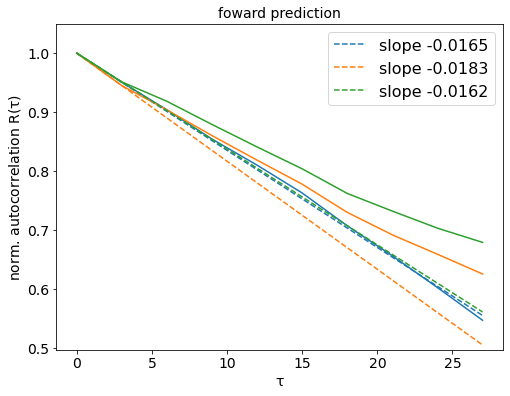

76


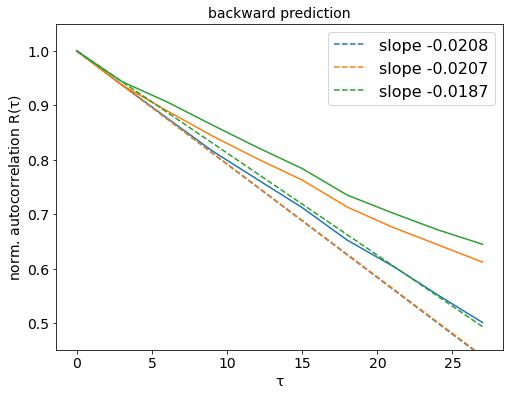

In [13]:
p_indices = [0,1,2]
for p, title in [  (paths_true, "true"), 
            (paths_prediction, "combined prediction"), 
            (paths_prediction_f, "foward prediction"), 
            (paths_prediction_b, "backward prediction")]:       

    print(len(p))
    sample_paths = [p[i] for i in p_indices] 

    plot_auto_corr_paths(sample_paths, 10, 3, OU="lt", title=title, ylim=[0.4, 1.1])